In [1]:
import numpy as np
import pandas as pd
from dropblock import DropBlock2D
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import warnings
# Filter the append warning from pandas
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train model on Fasion MNIST

In [3]:
train_set = torchvision.datasets.FashionMNIST("./fashion_mnist_data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
init_test_set = torchvision.datasets.FashionMNIST("./fashion_mnist_data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))
torch.manual_seed(42)

In [4]:
train_loader = DataLoader(train_set, batch_size=100)
init_test_loader = DataLoader(init_test_set, batch_size=100)

In [5]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [6]:
len(train_set), len(init_test_set)

(60000, 10000)

9


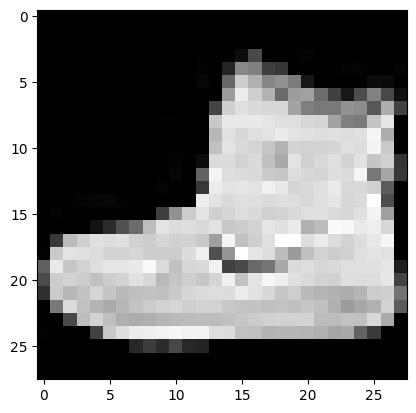

In [7]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [8]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

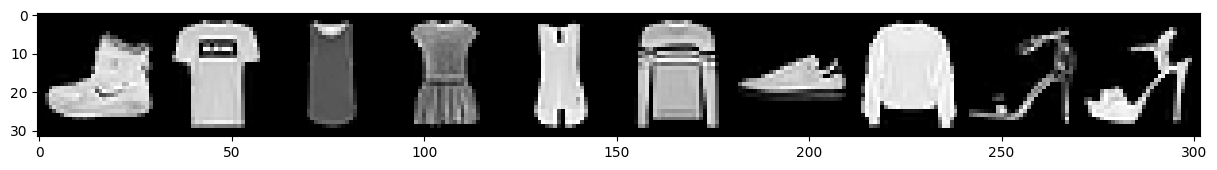

In [9]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [12]:
DROPBLOCK_PROB = 0.25
class FashionCNN(nn.Module):

    def __init__(self):
        super(FashionCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.dropblock1 = DropBlock2D(drop_prob=DROPBLOCK_PROB, block_size=3)
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        # Dropblock for catching the OoD
        self.dropblock2 = DropBlock2D(drop_prob=DROPBLOCK_PROB, block_size=3)
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.relu1 = nn.ReLU()
        self.drop = nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.dropblock1(out)
        out = self.layer3(out)
        out = self.dropblock2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [13]:
model: FashionCNN = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropblock1): DropBlock2D()
  (layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (dropblock2): DropBlock2D()
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (relu1): ReLU()
  (drop): Dropout2d(p=0.5, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=Tr

In [14]:
num_epochs = 10
count = 0
# Lists for visualization of loss and accuracy
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        # Forward pass
        outputs = model(train)
        loss = error(outputs, labels)

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()

        count += 1

    # Testing the model

        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0

            for images, labels in init_test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)

                test = Variable(images.view(100, 1, 28, 28))

                outputs = model(test)

                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()

                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/volatile/home/dm274516/anaconda3/envs/p38_vos_env/lib/python3.8/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.5061180591583252, Accuracy: 84.86000061035156%
Iteration: 1000, Loss: 0.39709216356277466, Accuracy: 86.30999755859375%
Iteration: 1500, Loss: 0.34035518765449524, Accuracy: 87.19999694824219%
Iteration: 2000, Loss: 0.392821341753006, Accuracy: 88.00999450683594%
Iteration: 2500, Loss: 0.3086497485637665, Accuracy: 88.37999725341797%
Iteration: 3000, Loss: 0.27117955684661865, Accuracy: 88.43000030517578%
Iteration: 3500, Loss: 0.3033960163593292, Accuracy: 88.52999877929688%
Iteration: 4000, Loss: 0.2788616418838501, Accuracy: 88.55999755859375%
Iteration: 4500, Loss: 0.24089856445789337, Accuracy: 88.83999633789062%
Iteration: 5000, Loss: 0.27169328927993774, Accuracy: 89.0199966430664%
Iteration: 5500, Loss: 0.2395397573709488, Accuracy: 89.91999816894531%
Iteration: 6000, Loss: 0.2426513433456421, Accuracy: 89.2699966430664%


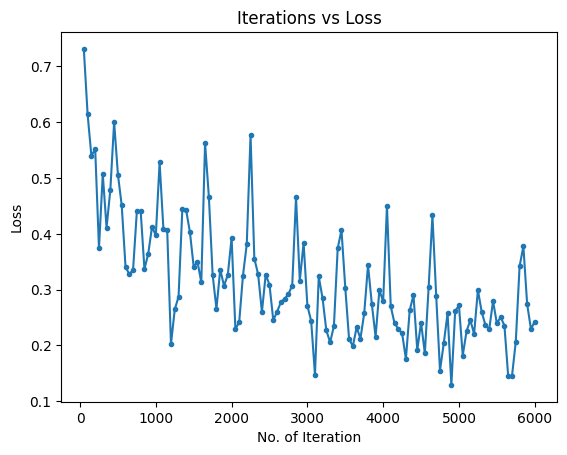

In [15]:
plt.plot(iteration_list, [loss.cpu() for loss in loss_list], '.-')
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

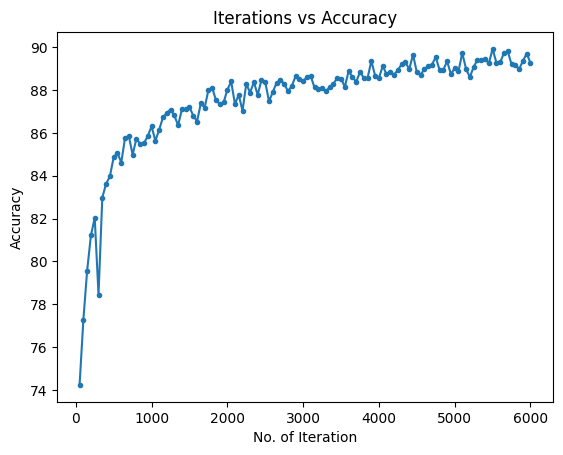

In [16]:
plt.plot(iteration_list, [acc.cpu() for acc in accuracy_list], ".-")
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [17]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in init_test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()

        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1

for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 90.30%
Accuracy of Trouser: 97.90%
Accuracy of Pullover: 89.50%
Accuracy of Dress: 91.10%
Accuracy of Coat: 83.50%
Accuracy of Sandal: 94.90%
Accuracy of Shirt: 59.20%
Accuracy of Sneaker: 95.10%
Accuracy of Bag: 97.60%
Accuracy of Ankle Boot: 96.40%


In [18]:
from itertools import chain

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [19]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.83      0.82      0.82    120000
           1       0.98      0.97      0.97    120000
           2       0.81      0.82      0.81    120000
           3       0.87      0.89      0.88    120000
           4       0.77      0.82      0.80    120000
           5       0.96      0.95      0.96    120000
           6       0.69      0.63      0.66    120000
           7       0.92      0.94      0.93    120000
           8       0.96      0.96      0.96    120000
           9       0.95      0.94      0.95    120000

    accuracy                           0.88   1200000
   macro avg       0.87      0.88      0.87   1200000
weighted avg       0.87      0.88      0.87   1200000




In [20]:
from itertools import chain

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [21]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.83      0.82      0.82    120000
           1       0.98      0.97      0.97    120000
           2       0.81      0.82      0.81    120000
           3       0.87      0.89      0.88    120000
           4       0.77      0.82      0.80    120000
           5       0.96      0.95      0.96    120000
           6       0.69      0.63      0.66    120000
           7       0.92      0.94      0.93    120000
           8       0.96      0.96      0.96    120000
           9       0.95      0.94      0.95    120000

    accuracy                           0.88   1200000
   macro avg       0.87      0.88      0.87   1200000
weighted avg       0.87      0.88      0.87   1200000




# Get MCD Samples

With MNIST as OoD

In [22]:
# Split test set into valid and test sets
from sklearn.model_selection import train_test_split
valid_set, test_set = train_test_split(init_test_set, test_size=0.2, random_state=42)
valid_data_loader = DataLoader(valid_set, batch_size=1)
test_data_loader = DataLoader(test_set, batch_size=1)

In [23]:
# Load MNIST
mnist_test_data = torchvision.datasets.MNIST('./mnist_data/', train=False, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
valid_set_mnist, test_set_mnist = train_test_split(mnist_test_data, test_size=0.2, random_state=42)
# MNIST test set loader
mnist_test_loader = DataLoader(test_set_mnist, batch_size=1, shuffle=True)

In [24]:
len(valid_set_mnist), len(test_set_mnist)

(8000, 2000)

In [25]:
len(valid_set), len(test_set)

(8000, 2000)

In [26]:
from ls_ood_detect_cea.uncertainty_estimation import Hook, deeplabv3p_apply_dropout

hooked_dropout_layer = Hook(model.dropblock2)
# Put model in evaluation mode
model.eval()
# Activate Dropout layers
model.apply(deeplabv3p_apply_dropout)
MCD_RUNS = 10

In [27]:
from TDL_helper_functions import get_ls_mcd_samples_fashion

fashion_valid_mc_samples = get_ls_mcd_samples_fashion(
        model=model,
        data_loader=valid_data_loader,
        mcd_nro_samples=MCD_RUNS,
        hook_dropout_layer=hooked_dropout_layer,
        layer_type="Conv",
        device=device
    )

Extracting MCD samples:   0%|          | 0/8000 [00:00<?, ?it/s]/volatile/home/dm274516/anaconda3/envs/p38_vos_env/lib/python3.8/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Extracting MCD samples: 100%|██████████| 8000/8000 [01:10<00:00, 113.95it/s]


In [28]:
fashion_valid_mc_samples.shape

torch.Size([80000, 384])

In [29]:
fashion_test_mc_samples = get_ls_mcd_samples_fashion(
        model=model,
        data_loader=test_data_loader,
        mcd_nro_samples=MCD_RUNS,
        hook_dropout_layer=hooked_dropout_layer,
        layer_type="Conv",
        device=device
    )

Extracting MCD samples: 100%|██████████| 2000/2000 [00:16<00:00, 121.10it/s]


In [30]:
mnist_test_mc_samples = get_ls_mcd_samples_fashion(
        model=model,
        data_loader=mnist_test_loader,
        mcd_nro_samples=MCD_RUNS,
        hook_dropout_layer=hooked_dropout_layer,
        layer_type="Conv",
        device=device
    )

Extracting MCD samples: 100%|██████████| 2000/2000 [00:16<00:00, 120.83it/s]


In [31]:
fashion_valid_mc_samples.shape, fashion_test_mc_samples.shape, mnist_test_mc_samples.shape

(torch.Size([80000, 384]), torch.Size([20000, 384]), torch.Size([20000, 384]))

## Calculate entropy

In [32]:
from ls_ood_detect_cea.uncertainty_estimation import get_dl_h_z

_, fashion_valid_h_z_np = get_dl_h_z(
    fashion_valid_mc_samples,
    mcd_samples_nro=MCD_RUNS,
)
# Calculate entropy fashion test set
_, fashion_test_h_z_np = get_dl_h_z(
    fashion_test_mc_samples,
    mcd_samples_nro=MCD_RUNS,
)
# Calculate entropy ood test set
_, ood_h_z_np = get_dl_h_z(
    mnist_test_mc_samples,
    mcd_samples_nro=MCD_RUNS,
)

Calculating entropy: 100%|██████████| 2000/2000 [00:52<00:00, 38.15it/s]


In [36]:
fashion_valid_h_z_np

array([[ -8.52054765, -10.07414336,  -6.7243224 , ..., -10.07414336,
        -10.07414336, -10.07414336],
       [-10.07414336,  -0.1424843 , -10.07414336, ..., -10.07414336,
         -9.21769278, -10.07414336],
       [-10.07414336,  -8.50223722,  -9.10630464, ...,  -8.49143612,
        -10.07414336, -10.07414336],
       ...,
       [ -9.18461011, -10.07414336,  -9.05096679, ...,  -2.83650638,
         -1.44255343, -10.07414336],
       [ -9.17470185,  -0.52848883, -10.07414336, ...,  -0.47827636,
         -1.53258564, -10.07414336],
       [-10.07414336,  -1.50598349,  -7.5029255 , ...,  -9.15556277,
         -9.05414008, -10.07414336]])

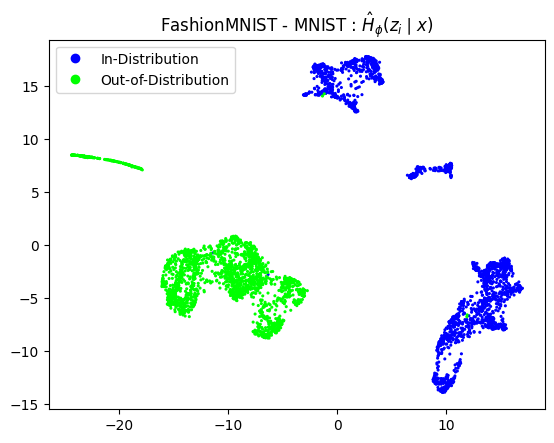

In [37]:
from ls_ood_detect_cea import plot_samples_pacmap

pacmap_2d_proj_plot = plot_samples_pacmap(samples_ind=fashion_test_h_z_np,
                                          samples_ood=ood_h_z_np,
                                          neighbors=10,
                                          title="FashionMNIST - MNIST : $\hat{H}_{\phi}(z_i \mid x)$",
                                          return_figure=False)

Evaluating PCA: 100%|██████████| 9/9 [00:34<00:00,  3.81s/it]


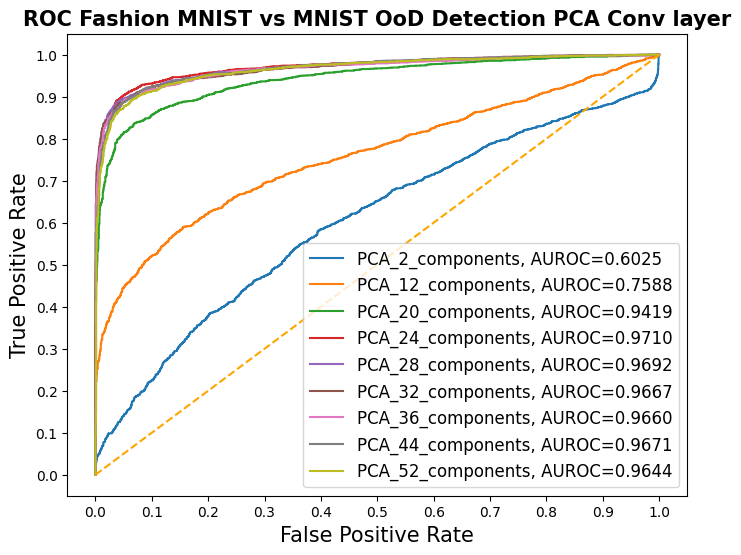

In [35]:
from detection.TDL_helper_functions import fit_evaluate_KDE
from ls_ood_detect_cea import apply_pca_ds_split, apply_pca_transform, get_hz_detector_results, plot_roc_ood_detector

pca_metrics = pd.DataFrame(columns=['auroc', 'fpr@95', 'aupr',
                                    'fpr', 'tpr', 'roc_thresholds',
                                    'precision', 'recall', 'pr_thresholds'])
n_pca_components = [2, 12, 20, 24, 28, 32, 36, 44, 52]
for n_components in tqdm(n_pca_components, desc="Evaluating PCA"):
    # Perform PCA dimension reduction
    pca_h_z_bdd_valid_samples, pca_transformation = apply_pca_ds_split(samples=fashion_valid_h_z_np,
                                                                       nro_components=n_components)
    pca_h_z_bdd_test_samples = apply_pca_transform(fashion_test_h_z_np, pca_transformation)
    pca_h_z_ood_samples = apply_pca_transform(ood_h_z_np, pca_transformation)

    # Build OoD detector
    scores_bdd_test, scores_ood = fit_evaluate_KDE(h_z_ind_valid_samples=pca_h_z_bdd_valid_samples,
                                                   h_z_ind_test_samples=pca_h_z_bdd_test_samples,
                                                   h_z_ood_samples=pca_h_z_ood_samples,
                                                   normalize=False)

    results_ood = get_hz_detector_results(detect_exp_name=f"PCA_{n_components}_components",
                                          ind_samples_scores=scores_bdd_test,
                                          ood_samples_scores=scores_ood,
                                          return_results_for_mlflow=False)

    pca_metrics = pca_metrics.append(results_ood)
# Plot all PCA evaluations in one figure
roc_curves_pca = plot_roc_ood_detector(
    results_table=pca_metrics,
    legend_title="",
    plot_title=f"ROC Fashion MNIST vs MNIST OoD Detection PCA Conv layer"
)

In [54]:
# Trained without dropblock, hook on the ReLU before the dropblock
pca_metrics

,auroc,fpr@95,aupr,fpr,tpr,roc_thresholds,precision,recall,pr_thresholds
PCA_2_components,0.465641,0.9945,0.474795,"[0.0, 0.0, 0.0005000000237487257, 0.0005000000...","[0.0, 0.0005000000237487257, 0.000500000023748...","[-1.6459557847139648, -2.6459557847139648, -2....","[0.5, 0.4998749792575836, 0.4997498691082001, ...","[1.0, 0.9994999766349792, 0.9990000128746033, ...","[-3.892190511278571, -3.8803795440781554, -3.8..."
PCA_12_components,0.757296,0.6970,0.656927,"[0.0, 0.0, 0.0005000000237487257, 0.0010000000...","[0.0, 0.0005000000237487257, 0.000500000023748...","[-13.228311164580326, -14.228311164580326, -14...","[0.5012531280517578, 0.501128077507019, 0.5012...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-20.87981691816562, -20.87638166889735, -20.8..."
PCA_20_components,0.824561,0.4700,0.714517,"[0.0, 0.0005000000237487257, 0.001000000047497...","[0.0, 0.0, 0.0, 0.0005000000237487257, 0.00050...","[-21.370926738071304, -22.370926738071304, -22...","[0.5018820762634277, 0.501757025718689, 0.5018...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-33.96008951354172, -33.95480287362482, -33.9..."
PCA_24_components,0.827409,0.5045,0.720231,"[0.0, 0.0, 0.0005000000237487257, 0.0005000000...","[0.0, 0.0005000000237487257, 0.000500000023748...","[-25.386174681650957, -26.386174681650957, -26...","[0.5006257891654968, 0.5005007386207581, 0.500...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-42.88612518621521, -42.79349361650193, -42.5..."
PCA_28_components,0.832996,0.4895,0.728046,"[0.0, 0.0, 0.0, 0.0005000000237487257, 0.00050...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-29.37965603544304, -30.37965603544304, -30.3...","[0.5033979415893555, 0.5032728910446167, 0.503...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-48.67589776628668, -48.671941179183605, -48...."
PCA_32_components,0.843062,0.4330,0.738605,"[0.0, 0.0, 0.0, 0.0, 0.0005000000237487257, 0....","[0.0, 0.0005000000237487257, 0.001000000047497...","[-33.27021445408254, -34.27021445408254, -34.3...","[0.5104645490646362, 0.5103395581245422, 0.510...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-55.09799259416885, -55.06868894727838, -55.0..."
PCA_36_components,0.858566,0.3370,0.752260,"[0.0, 0.0, 0.0005000000237487257, 0.0005000000...","[0.0, 0.0005000000237487257, 0.000500000023748...","[-37.21281051314955, -38.21281051314955, -38.2...","[0.5129520297050476, 0.5128270983695984, 0.512...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-62.68541953140192, -62.68289832053646, -62.6..."
PCA_44_components,0.858102,0.3310,0.750117,"[0.0, 0.0005000000237487257, 0.000500000023748...","[0.0, 0.0, 0.0005000000237487257, 0.0010000000...","[-44.98144991164228, -45.98144991164228, -46.0...","[0.5063291192054749, 0.5062041282653809, 0.506...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-77.62615991624067, -77.59846042917098, -77.5..."
PCA_52_components,0.852683,0.3360,0.749442,"[0.0, 0.0005000000237487257, 0.000500000023748...","[0.0, 0.0, 0.0005000000237487257, 0.0005000000...","[-52.76613629002984, -53.76613629002984, -53.7...","[0.5126890540122986, 0.5125641226768494, 0.512...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-91.60120684257203, -91.58793424678187, -91.5..."


In [37]:
# Trained without dropblock, hook on dropblock
pca_metrics

,auroc,fpr@95,aupr,fpr,tpr,roc_thresholds,precision,recall,pr_thresholds
PCA_2_components,0.497433,0.9985,0.493191,"[0.0, 0.0, 0.0, 0.0005000000237487257, 0.00050...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-1.6301621244920694, -2.6301621244920694, -2....","[0.5, 0.4998749792575836, 0.4997498691082001, ...","[1.0, 0.9994999766349792, 0.9990000128746033, ...","[-3.8879138998807994, -3.854399525616066, -3.8..."
PCA_12_components,0.856587,0.6450,0.876857,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-13.878937903616507, -14.878937903616507, -14...","[0.5017561316490173, 0.5016311407089233, 0.501...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-20.57721674508949, -20.562906459360782, -20...."
PCA_20_components,0.930799,0.3860,0.942312,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-22.571465741082164, -23.571465741082164, -23...","[0.5045408606529236, 0.5044158697128296, 0.504...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-33.422955593974955, -33.40935715961221, -33...."
PCA_24_components,0.928877,0.4435,0.942060,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-26.803215463208836, -27.803215463208836, -27...","[0.5012531280517578, 0.501128077507019, 0.5012...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-41.08607427802659, -41.05283211287757, -41.0..."
PCA_28_components,0.953336,0.2915,0.961650,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-31.295040930702832, -32.29504093070283, -32....","[0.5149330496788025, 0.5148081183433533, 0.514...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-46.71114509226316, -46.692883812619826, -46...."
PCA_32_components,0.964242,0.2110,0.970323,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-35.58979509696576, -36.58979509696576, -36.7...","[0.5151983499526978, 0.5150734186172485, 0.515...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-54.27372949083971, -54.2152447712948, -54.21..."
PCA_36_components,0.970806,0.1650,0.974743,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-40.08722082634665, -41.08722082634665, -41.1...","[0.5260389447212219, 0.5259142518043518, 0.526...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-61.23211630587435, -61.21381573610679, -61.2..."
PCA_44_components,0.969434,0.1630,0.973229,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-48.54917073594667, -49.54917073594667, -49.9...","[0.5051780939102173, 0.5050530433654785, 0.505...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-76.90654100963556, -76.88810136146627, -76.8..."
PCA_52_components,0.966086,0.1865,0.971436,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-57.004756797884056, -58.004756797884056, -58...","[0.5102040767669678, 0.5100790858268738, 0.510...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-90.0016810773684, -89.98902870671043, -89.93..."


In [38]:
# Trained with dropblock, hook on dropblock
pca_metrics

,auroc,fpr@95,aupr,fpr,tpr,roc_thresholds,precision,recall,pr_thresholds
PCA_2_components,0.500878,1.0000,0.527328,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-1.6184887792902698, -2.61848877929027, -2.61...","[0.5, 0.4998749792575836, 0.4997498691082001, ...","[1.0, 0.9994999766349792, 0.9990000128746033, ...","[-3.831886878983222, -3.829030609608818, -3.80..."
PCA_12_components,0.869446,0.6765,0.893646,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-13.542576998242868, -14.542576998242868, -14...","[0.5010020136833191, 0.5008769631385803, 0.501...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-19.41381468913869, -19.353500786553422, -19...."
PCA_20_components,0.934748,0.4370,0.948851,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-22.240336665664785, -23.240336665664785, -23...","[0.5012531280517578, 0.501128077507019, 0.5012...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-33.19899482867517, -33.19101691031886, -33.1..."
PCA_24_components,0.966299,0.1945,0.972476,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-26.76932166411791, -27.76932166411791, -27.7...","[0.503524661064148, 0.503399670124054, 0.50352...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-39.707546481757966, -39.70584790874905, -39...."
PCA_28_components,0.970042,0.1690,0.975122,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-31.161771362497916, -32.161771362497916, -32...","[0.5099439024925232, 0.5098189115524292, 0.509...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-46.34853476996222, -46.3458028621081, -46.32..."
PCA_32_components,0.970071,0.1730,0.974656,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-35.76901124076251, -36.76901124076251, -36.7...","[0.517196774482727, 0.5170719027519226, 0.5172...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-52.696997490527465, -52.69131785705607, -52...."
PCA_36_components,0.967520,0.2025,0.972319,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-39.979670225242884, -40.979670225242884, -41...","[0.5351886749267578, 0.5350642204284668, 0.535...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-58.5763413188997, -58.57544271300235, -58.57..."
PCA_44_components,0.962555,0.2195,0.966669,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-48.44498271759923, -49.44498271759923, -49.8...","[0.5496015548706055, 0.549477756023407, 0.5496...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-71.84204247385206, -71.8110061012781, -71.80..."
PCA_52_components,0.965891,0.1765,0.968880,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0005000000237487257, 0.001000000047497...","[-56.69401554400279, -57.69401554400279, -58.3...","[0.5219206809997559, 0.5217958688735962, 0.521...","[1.0, 0.9994999766349792, 0.9994999766349792, ...","[-86.8826879153448, -86.86512575024399, -86.83..."
